In [1]:
high_comms = '/Users/antoniaboca/vs_code/R255/self_interested_comms/results/MultiPPOTrainer_2023-03-12_01-18-20/MultiPPOTrainer_coverage_c6baf_00000_0_2023-03-12_01-18-20/checkpoint_000900'
high_no_comms = '/Users/antoniaboca/vs_code/R255/self_interested_comms/results/MultiPPOTrainer_2023-03-12_03-58-40/MultiPPOTrainer_coverage_2ce12_00000_0_2023-03-12_03-58-41/checkpoint_000900'
low_comms = '/Users/antoniaboca/vs_code/R255/self_interested_comms/results/MultiPPOTrainer_2023-03-12_18-08-39/MultiPPOTrainer_coverage_ea8ac_00000_0_2023-03-12_18-08-39/checkpoint_000900'
low_no_comms = '/Users/antoniaboca/vs_code/R255/self_interested_comms/results/MultiPPOTrainer_2023-03-12_18-11-22/MultiPPOTrainer_coverage_4b8bb_00000_0_2023-03-12_18-11-22/checkpoint_000900'


In [2]:
import torch

/Users/antoniaboca/miniconda3/envs/r255-python3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
import pickle
with open('comms_dataset.pkl', 'rb') as handle:
    comms_dataset = pickle.load(handle)

In [46]:
from interpreter import CoverageDataset
from torch.utils.data import DataLoader
comms_dataset = CoverageDataset('comms_dataset.pkl')

In [12]:
comms_dataset = samples

In [21]:
example = get_xth_agent(0, 0)

In [22]:
from interpreter import Interpreter
import torch

interpreter = Interpreter(example['x'].shape[1], 1e-4)
interpreter.load_state_dict(torch.load('r255-marl/tom9fewi/checkpoints/epoch=78-step=493750.ckpt')['state_dict'])

<All keys matched successfully>

In [17]:
import numpy as np

X = 1
Y = 0

ROW = 0
COL = 1

def local_frame(m, output_shape, pose, fill=0):
    half_out_shape = np.array(output_shape)
    padded = np.pad(m,([half_out_shape[Y]]*2,[half_out_shape[X]]*2), mode='constant', constant_values=fill)
    return torch.tensor(padded[pose[Y]:pose[Y] + output_shape[Y], pose[X]:pose[X] + output_shape[Y]])


In [15]:
import colorsys
def generate_color(agent_id):
            # Scale the agent ID to the range [0, 1]
            normalized_id = agent_id / 8 + 0.1
            
            # Use the HSV color space to generate a color
            hue = normalized_id
            saturation = 0.8
            value = 0.8
            r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)
            
            # Convert the RGB color to a hex string
            hex_color = '#{:02x}{:02x}{:02x}'.format(int(r * 255), int(g * 255), int(b * 255))
            
            return hex_color

In [14]:
def _agent_generator(item):
    n_agents = len(item['obs']['agents'])
    for a_id in range(n_agents):
        agent_state = item['obs']['agents'][a_id]['map']
        agent_pos = item['obs']['agents'][a_id]['pos']
        agent_obs = item['feats'][a_id]
        obs_map = torch.tensor(agent_state[..., 0])
        obs_cov = torch.tensor(agent_state[..., 1])
        label = torch.stack([obs_map, obs_cov], axis=0)

        weight = torch.ones_like(obs_map)
        weight = local_frame(weight, obs_map.shape, agent_pos, fill=0)
        weight = torch.stack([weight] * 2, axis=0)

        yield {'x': agent_obs.unsqueeze(0), 'w': weight.unsqueeze(0), 'y': label.unsqueeze(0), 'obs': item['obs']}

In [16]:
def get_composite_ground_truth(agent_id, sample):
    feats = sample['x']
    maps = sample['y']
    maps = maps.squeeze(0)
    obs_map = maps[0, ...]
    cov_map = maps[1, ...]
    
    total_map = 5 * obs_map + agent_id * cov_map
    total_map[total_map >= 6] = 5
    return total_map

def get_composite_predicted(agent_id, sample):
    obs_map, cov_map = interpreter.forward(sample)
    obs_map = obs_map.squeeze(0).squeeze(0)
    cov_map = cov_map.squeeze(0).squeeze(0)

    # obs_comp = torch.fill(obs_map, 6)
    # obs_comp[obs_map > 0.7] = 5.0
    # obs_comp[obs_map < 0.3] = 0.0

    # cov_comp = torch.fill(cov_map, 6)
    # cov_comp[cov_map > 0.6] = agent_id
    # cov_comp[cov_map < 0.10] = 0.0

    return obs_map, cov_map

def get_composite_global(sample):
    coverage = sample['state'][:, :, 1]
    maps = sample['state'][:, :, 0]
    mapcov= coverage + 5 * maps
    for agent in sample['agents']:
        pos = agent['pos']
        mapcov[pos[0]][pos[1]] = 6
    return mapcov




In [20]:
comms_dataset = samples

In [19]:

def get_agents_gen(iter):
    return _agent_generator(comms_dataset[iter])

def get_xth_agent(iter, agent_id):
    gen = get_agents_gen(iter)
    agent = next(gen)
    for idx in range(agent_id):
        agent = next(gen)
    return agent

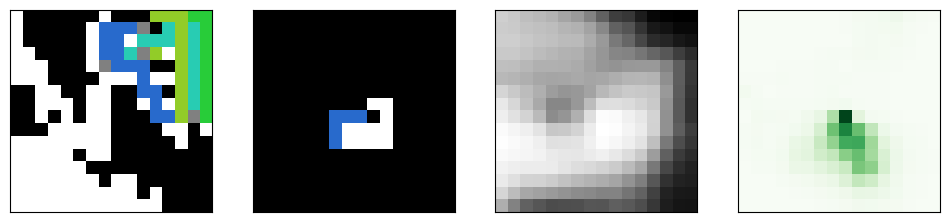

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

xth = 3
example = get_xth_agent(24, xth)
# create a sample matrix
obs_map, cov_map = get_composite_predicted(xth+1, example)
ground_truth = get_composite_ground_truth(xth+1, example)
globals = get_composite_global(example['obs'])


# define a custom color map
cmap = ListedColormap(['white', generate_color(1), generate_color(2), generate_color(3), generate_color(4), 'black', 'grey'])

fig, ax = plt.subplots(1, 4, figsize=(12, 4))
im = ax[2].imshow(obs_map.detach().numpy(), cmap='gray_r')
im1 = ax[3].imshow(cov_map.detach().numpy(), cmap='Greens')
im2 = ax[1].imshow(ground_truth, cmap=cmap, vmin=0, vmax=6)
im3 = ax[0].imshow(globals, cmap=cmap, vmin=0, vmax=6)
# ax[0].set_title('Global map')
# ax[1].set_title('Local true map')
# ax[2].set_title('Predicted obstacles')
# ax[3].set_title('Predicted coverage')
for idx in range(4):
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    ax[idx].set_xticklabels([])
    ax[idx].set_yticklabels([])
# show the plot
plt.show()

In [36]:
cov_map

tensor([[0.0355, 0.0445, 0.0426, 0.0511, 0.0600, 0.0615, 0.1046, 0.0710, 0.0497,
         0.1150, 0.1320, 0.1127, 0.1166, 0.0893, 0.0698, 0.0600],
        [0.0344, 0.0428, 0.0405, 0.0485, 0.0586, 0.0613, 0.0634, 0.0719, 0.1040,
         0.1269, 0.1243, 0.1051, 0.0915, 0.0653, 0.0470, 0.0407],
        [0.0378, 0.0482, 0.0468, 0.0578, 0.1383, 0.0641, 0.0424, 0.0597, 0.0452,
         0.0845, 0.0905, 0.0769, 0.0744, 0.0537, 0.0378, 0.0324],
        [0.0610, 0.0782, 0.0755, 0.0946, 0.0958, 0.1073, 0.1100, 0.1280, 0.2064,
         0.1322, 0.0918, 0.0855, 0.0699, 0.0496, 0.0333, 0.0282],
        [0.0962, 0.1240, 0.1333, 0.1461, 0.1346, 0.1431, 0.1718, 0.1712, 0.2127,
         0.1621, 0.1215, 0.1019, 0.0712, 0.0514, 0.0331, 0.0288],
        [0.1379, 0.1787, 0.1610, 0.2013, 0.1755, 0.2083, 0.2106, 0.2515, 0.3527,
         0.1556, 0.1112, 0.0863, 0.0597, 0.0458, 0.0296, 0.0247],
        [0.2036, 0.1983, 0.2066, 0.2083, 0.1472, 0.2992, 0.3132, 0.3721, 0.3722,
         0.1600, 0.1075, 0.0657, 0.04

In [ ]:
obs, cov = interpreter.forward(example)

In [ ]:
obs = obs.squeeze(0).squeeze(0)

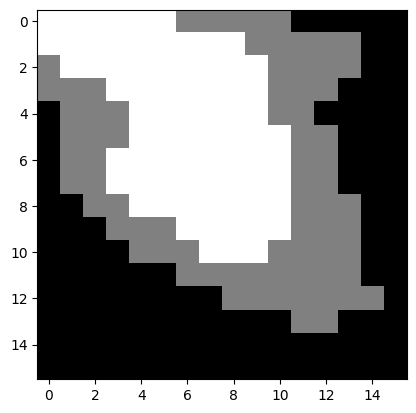

In [ ]:
map = torch.fill(obs, 0.1)
map[obs > 0.7] = 2.0
map[obs < 0.3] = 0.0

new_cmap = ListedColormap(['white', 'gray', 'black'])
fig, ax = plt.subplots()
im = ax.imshow(pred, cmap=new_cmap)
plt.show()

In [3]:
import ray
from ray.tune.registry import register_env
from ray.rllib.models import ModelCatalog
from ray.rllib.algorithms.algorithm import Algorithm
from main_2 import CustomCallbacks
from action_distribution import TorchHomogeneousMultiActionDistribution
from coverage_2 import CoverageEnv
from model import AdversarialModel
from trainer_2 import MultiPPOTrainer

config={
            "callbacks": CustomCallbacks,
            "output": './eval_trace/',
            "framework": "torch",
            "env": "coverage",
            "use_gae": True,
            'use_critic': True,
            "kl_coeff": 0.5,
            "lambda": 0.95,
            "clip_param": 0.2,
            "entropy_coeff": 0.01,
            "train_batch_size": 1000,
            "rollout_fragment_length": 45,
            "sgd_minibatch_size": 100,
            "num_sgd_iter": 5,
            "num_gpus": 0,
            "num_workers": 1,
            "num_envs_per_worker": 1,
            "lr": 5e-4,
            "gamma": 0.9,
            "batch_mode": "truncate_episodes",
            "observation_filter": "NoFilter",
            "model": {
                "custom_model": "adversarial",
                "custom_action_dist": "hom_multi_action",
                "custom_model_config": {
                    'graph_layers': 1,
                    'graph_tabs': 2,
                    'graph_edge_features': 1,
                    'graph_features': 32,
                    'cnn_filters': [[8, [4, 4], 2], [16, [4, 4], 2], [32, [3, 3], 2]],
                    'value_cnn_filters': [[8, [4, 4], 2], [16, [4, 4], 2], [32, [4, 4], 2]],
                    'value_cnn_compression': 32,
                    'cnn_compression': 32,
                    'pre_gnn_mlp': [64, 128, 32],
                    'gp_kernel_size': 16,
                    'graph_aggregation': 'sum',
                    'relative': True,
                    'activation': 'relu',
                    'freeze_coop': False,
                    'freeze_greedy': False,
                    'freeze_coop_value': False,
                    'freeze_greedy_value': False,
                    'cnn_residual': False,
                    'agent_split': 1,
                    'greedy_mse_fac': 0.0,
                    'disable_comms': False,
                },
            },
            "env_config": {
                'world_shape': [16, 16],
                'state_size': 8,
                'collapse_state': False,
                'termination_no_new_coverage': 10,
                'max_episode_len': 154, # 16 * 16 * 0.6
                'n_agents': 4,
                'disabled_teams_step': [True, False],
                'disabled_teams_comms': [True, False],
                'min_coverable_area_fraction': 0.6,
                'map_mode': 'random',
                'reward_annealing': 0.0,
                'communication_range': 100.0,
                'ensure_connectivity': True,
                'reward_type': 'semi_cooperative', #semi_cooperative/cooperative
                'episode_termination': 'early', # early/fixed/default
                'operation_mode': 'coop_only',
            },
            'create_env_on_driver': True,
            'evaluation_config': {
                'explore': True,
                'evaluation_duration': 100,
                'evaluation_duration_unit': 'episodes',
                'evaluation_num_workers': 4
            }
        }

In [4]:
ray.shutdown()
ray.init()
register_env("coverage", lambda config: CoverageEnv(config))
ModelCatalog.register_custom_model("adversarial", AdversarialModel)
ModelCatalog.register_custom_action_dist(
    "hom_multi_action", TorchHomogeneousMultiActionDistribution
)

2023-03-15 19:27:51,536	INFO worker.py:1528 -- Started a local Ray instance.


In [5]:
trainer = MultiPPOTrainer(config)

2023-03-15 19:27:53,645	WARNING ppo.py:351 -- `train_batch_size` (1000) cannot be achieved with your other settings (num_workers=1 num_envs_per_worker=1 rollout_fragment_length=45)! Auto-adjusting `rollout_fragment_length` to 1000.
2023-03-15 19:27:53,646	INFO ppo.py:379 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2023-03-15 19:27:53,648	INFO algorithm.py:457 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2023-03-15 19:27:55,579	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=88166) 2023-03-15 19:27:55,510	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_s

In [ ]:
import gym
gym.__version__

'0.23.1'

In [6]:
trainer.restore(low_comms)

2023-03-15 19:28:02,698	INFO trainable.py:766 -- Restored on 127.0.0.1 from checkpoint: /Users/antoniaboca/vs_code/R255/self_interested_comms/results/MultiPPOTrainer_2023-03-12_18-08-39/MultiPPOTrainer_coverage_ea8ac_00000_0_2023-03-12_18-08-39/checkpoint_000900
2023-03-15 19:28:02,698	INFO trainable.py:775 -- Current state after restoring: {'_iteration': 900, '_timesteps_total': None, '_time_total': 26712.856531381607, '_episodes_total': 140171}


In [7]:
trainer.evaluate()

(raylet) [2023-03-15 19:28:11,525 E 88151 5907727] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-15_19-27-49_969168_88089 is over 95% full, available space: 17683972096; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2023-03-15 19:28:21,615 E 88151 5907727] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-15_19-27-49_969168_88089 is over 95% full, available space: 17674698752; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2023-03-15 19:28:31,707 E 88151 5907727] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-15_19-27-49_969168_88089 is over 95% full, available space: 17663340544; capacity: 494384795648. Object creation will fail if spilling is required.


{'evaluation': {'episode_reward_max': 146.0,
  'episode_reward_min': 12.0,
  'episode_reward_mean': 96.98936170212765,
  'episode_len_mean': 35.329787234042556,
  'episode_media': {},
  'episodes_this_iter': 282,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {'agent_reward_max_mean': 30.365248226950353,
   'agent_reward_max_min': 9,
   'agent_reward_max_max': 49,
   'agent_reward_min_mean': 17.865248226950353,
   'agent_reward_min_min': 0,
   'agent_reward_min_max': 32,
   'agent_reward_mean_mean': 24.247340425531913,
   'agent_reward_mean_min': 3.0,
   'agent_reward_mean_max': 36.5},
  'hist_stats': {'episode_reward': [129.0,
    119.0,
    125.0,
    99.0,
    125.0,
    79.0,
    29.0,
    113.0,
    91.0,
    119.0,
    95.0,
    106.0,
    73.0,
    98.0,
    66.0,
    101.0,
    71.0,
    82.0,
    111.0,
    110.0,
    108.0,
    103.0,
    127.0,
    20.0,
    127.0,
    94.0,
    87.0,
    113.0,
    115.0,
    109.0,
   

(raylet) [2023-03-15 19:28:41,801 E 88151 5907727] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-15_19-27-49_969168_88089 is over 95% full, available space: 17655017472; capacity: 494384795648. Object creation will fail if spilling is required.


In [32]:
model = trainer.get_policy().model

In [33]:
gnn_list = model.agent_gnns

Text(0, 0.5, 'Number of GNN parameters')

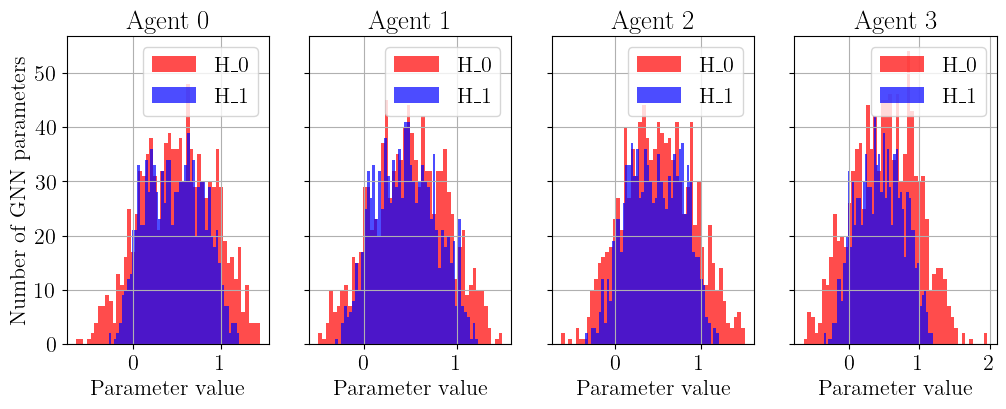

In [34]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.size'] = 16

fig, ax = plt.subplots(1, 4, figsize=(12, 4), sharey=True)

for idx in range(4):
    layer0 = gnn_list[idx].layers[0][0]
    layer1 = gnn_list[idx].layers[0][1]

    ax[idx].grid()
    ax[idx].hist(layer0.data.flatten(), bins=50, color='red', alpha=0.7)
    ax[idx].hist(layer1.data.flatten(), bins=50, color='blue', alpha=0.7)
    ax[idx].legend(['H_0', 'H_1'])
    ax[idx].set_title(f'Agent {idx}')
    ax[idx].set_xlabel('Parameter value')
ax[0].set_ylabel('Number of GNN parameters')

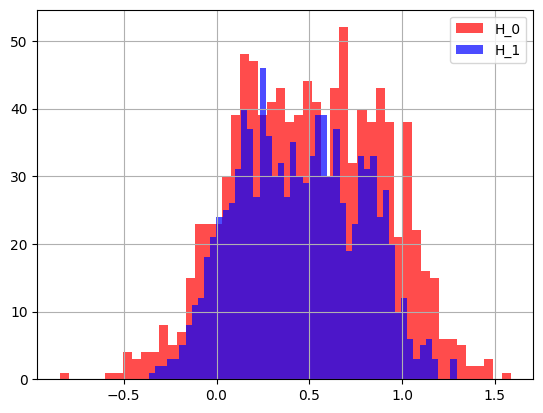

(raylet) [2023-03-15 19:01:29,149 E 86140 5831773] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-15_18-26-42_396373_86101 is over 95% full, available space: 17683816448; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2023-03-15 19:01:39,238 E 86140 5831773] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-15_18-26-42_396373_86101 is over 95% full, available space: 17683804160; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2023-03-15 19:01:49,322 E 86140 5831773] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-15_18-26-42_396373_86101 is over 95% full, available space: 17683660800; capacity: 494384795648. Object creation will fail if spilling is required.


In [72]:
plt.grid()
plt.hist(layer0.data.flatten(), bins=50, color='red', alpha=0.7)
plt.hist(layer1.data.flatten(), bins=50, color='blue', alpha=0.7)
plt.legend(['H_0', 'H_1'])

In [9]:
Xs = []
def record_gnn_input(module, input_, output):
    cnn_feats, gsos = input_
    Xs.append(cnn_feats)

model.agent_gnns[0].register_forward_hook(record_gnn_input)    

(raylet) [2023-03-15 19:29:01,989 E 88151 5907727] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-15_19-27-49_969168_88089 is over 95% full, available space: 17645486080; capacity: 494384795648. Object creation will fail if spilling is required.


In [ ]:
ray.shutdown()

In [10]:
import numpy as np
import copy 

env = CoverageEnv(config['env_config'])
env.seed(67)
obs = env.reset()
total_reward = 0
Xs = []

samples = []
sample_iterations = 50
frame_take_prob = 0.1

while len(samples) < sample_iterations:
    actions = trainer.compute_single_action(obs)
    assert Xs[0].shape[0] == 1
    cnn_feats = Xs[0].squeeze(0)
    Xs = []
    # assert cnn_feats.shape[0] == 1
    n_agents = int(cnn_feats.shape[0])
    assert n_agents == 4

    if np.random.rand() <= frame_take_prob:
        samples.append(copy.deepcopy({'obs': obs, 'actions': actions, 'feats': cnn_feats}))
        print(len(samples))
    
    obs, reward, done, info = env.step(actions)
    total_reward += reward
    
    if env.timestep > 153 or done:
        if total_reward >= 130:
            samples.append(copy.deepcopy({'obs': obs, 'actions': actions, 'feats': cnn_feats}))
            print(len(samples))

        obs = env.reset()
        total_reward = 0

import pickle
with open('test_dataset.pkl', 'wb') as handle:
    pickle.dump(samples, file=handle)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [11]:
ray.shutdown()

In [11]:
high_no_comm = samples

In [ ]:
low_comm = samples

(raylet) [2023-03-15 14:13:30,690 E 82452 5606139] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-15_14-12-38_631215_82418 is over 95% full, available space: 18051653632; capacity: 494384795648. Object creation will fail if spilling is required.
(raylet) [2023-03-15 14:13:40,770 E 82452 5606139] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2023-03-15_14-12-38_631215_82418 is over 95% full, available space: 18051547136; capacity: 494384795648. Object creation will fail if spilling is required.


In [ ]:
samples_over_60 = samples

In [ ]:
ray.shutdown()

In [ ]:
max_frac = 0
max_id = 0
top_ids = []

for id, sample in enumerate(samples_over_70):
    coverage = sample['obs']['state'][:, :, 1]
    covs = np.count_nonzero(coverage > 0)
    if covs >= 75:
        top_ids.append(id)
        if covs > max_frac:
            max_id = len(top_ids) - 1
            max_frac = covs

In [ ]:
max_frac = 0
max_id = 0
top_ids = []

for id, sample in enumerate(samples_over_70):
    coverage = sample['obs']['state'][:, :, 1]
    covs = np.count_nonzero(coverage > 0)
    if covs >= 80:
        top_ids.append(id)
        if covs > max_frac:
            max_id = len(top_ids) - 1
            max_frac = covs

In [ ]:
len(top_ids)

13

In [ ]:
import colorsys
def generate_color(agent_id):
            # Scale the agent ID to the range [0, 1]
            normalized_id = agent_id / 8 + 0.3
            
            # Use the HSV color space to generate a color
            hue = normalized_id
            saturation = 0.8
            value = 0.8
            r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)
            
            # Convert the RGB color to a hex string
            hex_color = '#{:02x}{:02x}{:02x}'.format(int(r * 255), int(g * 255), int(b * 255))
            
            return hex_color

In [ ]:
def get_composite(sample):
    coverage = sample['obs']['state'][:, :, 1]
    maps = sample['obs']['state'][:, :, 0]
    mapcov= coverage + 5 * maps
    for agent in sample['obs']['agents']:
        pos = agent['pos']
        mapcov[pos[0]][pos[1]] = 6
    return mapcov


In [ ]:
ray.shutdown()

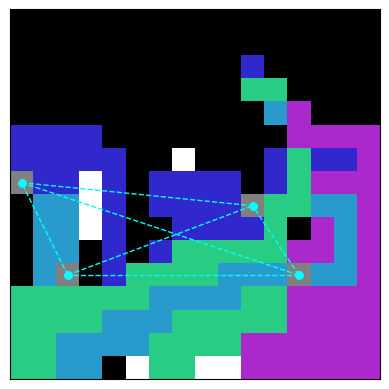

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# create a sample matrix
matrix = get_composite(high_comm[11])

# define a custom color map
cmap = ListedColormap(['white', generate_color(1), generate_color(2), generate_color(3), generate_color(4), 'black', 'grey'])

agents = [agent['pos'] for agent in high_comm[11]['obs']['agents']]
fig, ax = plt.subplots()
im = ax.imshow(matrix, cmap=cmap)

for idx_1, agent_1 in enumerate(agents):
    for idx_2, agent_2 in enumerate(agents):
        if idx_1 < idx_2:
            x_coords = [coord[1] for coord in [agent_1, agent_2]]
            y_coords = [coord[0] for coord in [agent_1, agent_2]]
            ax.plot(x_coords, y_coords, 'o--', color='cyan', linewidth=1, markersize=5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
# show the plot
plt.show()

In [ ]:
my_sample = samples_over_70[top_ids[4]]

In [ ]:
from interpreter import Interpreter

agent_feats = my_sample['feats'][0]

In [ ]:
local_world = my_sample['obs']['agents'][1]['map'][:, :, 0]
local_coverage = my_sample['obs']['agents'][1]['map'][:, :, 1]
local_robots = my_sample['obs']['agents'][1]['map'][:, :, 2]